# Tutorial: Informed Search Algorithms and CommonRoad Search

This tutorial shows how we can use motion primitives in informed search algorithms to find a trajectory that connects an **initial state** and a **goal region**.

## How to use this tutorial
Before you start with this tutorial, make sure that 
* you have read through the tutorial for [CommonRoad-io](https://commonroad.in.tum.de/static/docs/commonroad-io/index.html). Its tutorial can be found [here](https://commonroad.in.tum.de/tutorials/).
* you have installed all necessary modules for CommonRoad Search according to the installation manual.
* you have done the tutorial on uninformed search algorithms and CommonRoad Search. 


Let's start with importing the modules and loading the commonroad scenario. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append("../../GSMP/motion_automata")
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.draw_dispatch_cr import draw_object
from automata.HelperFunctions import load_scenario, generate_automata
from automata.helper_tree_search import *
import automata.tree_search as tree_search

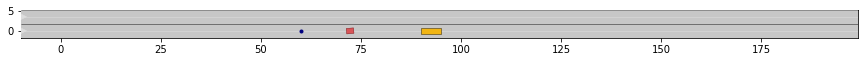

In [2]:
# Load scenario ZAM_Urban-3_2
scenario_path = '../../scenarios/tutorial/'
scenario_id = 'ZAM_Tutorial_Urban-3_2'

scenario, planning_problem_set = CommonRoadFileReader(scenario_path+scenario_id+'.xml').open()

# Plot scenario and planning problem set

plt.figure(figsize=(15, 5))
draw_object(scenario)
draw_object(planning_problem_set)
plt.gca().set_aspect('equal')
plt.margins(0, 0)
plt.show()

planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]

## Generating a Maneuver Automaton

In the following, we load the motion primitives from an XML-File and generate a Maneuver Automaton.
The maneuver automaton for this tutorial consists of 7 motion primitives and stores the connectivity to other motion primitives. 

Reading motion primitives...
Automata created.
Number of loaded primitives: 7


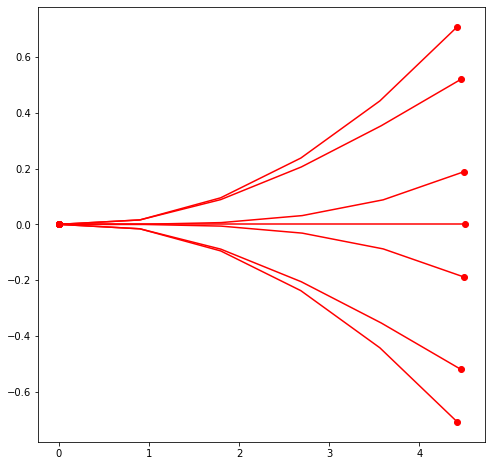

In [3]:
# Load motion primitives (mp)
mp_path = 'motion_primitives_search_tutorial/'
mp_file = 'V_9.0_9.0_Vstep_0_SA_-0.2_0.2_SAstep_0.4_T_0.5_Model_BMW320i.xml'

vehicle_type_id = 2
automaton = generate_automata(vehicle_type_id, mp_file= mp_path+mp_file, search_tutorial=True)

# plot motion primitives

plt.figure(figsize=(8,8))

for mp in automaton.Primitives:
    plot_motion_primitive(mp)
plt.show()



## Greedy-Best-First Search (GBFS)
As mentioned in the tutorial on uninformed search, GBFS is based on the Best-First Search and uses as evaluation function f(n) the heuristic cost h(n). For this application, we need a heuristic which estimates the time to reach the goal. Therefore, we calculate the euclidean distance of the final matched state to the goal region and divide it by the velocity in the final matched state. This is a very simple heuristic, but it works for our example.

Before we run the algorithm you can have a look at the implementation of the Best-First Search and the evaluation function.

```python
def search_alg(self):
    '''
    Implementation of Best-First Search (tree search) using a Priority queue
    '''
    # First node
    initial_node = PrioNode(path=[[self.initial_state]], primitives=[], tree_depth=0, current_cost=0)
   

    # add current node (i.e., current path and primitives) to the frontier
    f = self.evaluation_function(initial_node)
    self.frontier.insert(item=initial_node, priority=f)

    while not self.frontier.empty():
        # Pop the shallowest node
        current_node: PrioNode = self.frontier.pop()

        # Goal test
        if self.reached_goal(current_node.path[-1]):
            solution_path = self.remove_states_behind_goal(current_node.path)
     
            # return solution
            return solution_path, current_node.primitives

        # Check all possible successor primitives(i.e., actions) for current node
        for succ_primitive in current_node.get_successors():

            # translate/rotate motion primitive to current position
            current_primitive_list = copy.copy(current_node.primitives)
            path_translated = self.translate_primitive_to_current_state(succ_primitive, 
                                                                        current_node.path[-1])
            # check for collision, if is not collision free it is skipped
            if not self.check_collision_free(path_translated):
                continue

            current_primitive_list.append(succ_primitive)

            path_new = current_node.path + [[current_node.path[-1][-1]] + path_translated]
            child_node = PrioNode(path=path_new, primitives=current_primitive_list,
                                  tree_depth=current_node.tree_depth + 1, 
                                  current_cost=current_node.current_cost)
            f = self.evaluation_function(current_node=child_node)
            print(f)

            # Inserting the child into the frontier:
            self.frontier.insert(item=child_node, priority=f)

    return None, None

def evaluation_function(self, current_node: PrioNode) -> float:
    """
    Evaluation function of GBFS is f(n) = h(n)
    """

    current_node.current_cost = self.heuristic_function(current_node=current_node)
    return current_node.current_cost

```

Short reminder: When executing the following code block, you will see a "visualize" button directly beneath the "iteration" slider if you are running this notebook for the first time. Otherwise you can always find the button on the bottom.

Click the "visualize" button and let the search algorithm run through, once it's completed, you can use the slider to see all the iterations step by step.

In [4]:
gbfs_planner = tree_search.GreedyBestFirstSearch(scenario=scenario, planningProblem=planning_problem, 
                                                automaton=automaton)
scenario_data = scenario_data = (scenario, gbfs_planner.initial_state, gbfs_planner.egoShape, planning_problem)

# run the planner
display_steps(scenario_data=scenario_data, algorithm=gbfs_planner.search_alg, 
              config=gbfs_planner.config)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

## A* Search

A* uses the evaluation function f(n)= g(n) + h(n). So let's have a look at the new evaluation function and then let's run the A* Search.

```python
def evaluation_function(self, current_node: PrioNode) -> float:
    """
    Evaluation function of A* is f(n) = g(n) + h(n)
    """

    if self.reached_goal(current_node.path[-1]):
        current_node.path = self.remove_states_behind_goal(current_node.path)
    # calculate g(n)
    current_node.current_cost += len(current_node.path[-1]) * self.scenario.dt

    # f(n) = g(n) + h(n)
    return current_node.current_cost + self.heuristic_function(current_node=current_node)

```

In [5]:
astar_planner = tree_search.AStarSearch(scenario=scenario, planningProblem=planning_problem, 
                                                automaton=automaton)

# run the planner
display_steps(scenario_data=scenario_data, algorithm=astar_planner.search_alg, 
              config=astar_planner.config)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

Congratulations! You finished the tutorial on informed search and commonroad search. Now you are ready to implement your own search algorithms and heuristics to solve more complex planning problems.